In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def read_data_csv(filename):
    data = pd.read_csv(f"data/{filename}",sep=";")
    data.index = data["Phone timestamp"]
    data =data.drop(columns=["Phone timestamp","sensor timestamp [ns]"])
    data.index = pd.to_datetime(data.index)
    return data

In [17]:
data_passe_avant = read_data_csv("Passe_avant.csv")
data_passe_avant.head()

,X [mg],Y [mg],Z [mg]
Phone timestamp,,,
2021-11-16 22:13:35.886,-468,738,-449
2021-11-16 22:13:35.905,-591,718,-270
2021-11-16 22:13:35.925,-525,717,-294
2021-11-16 22:13:35.944,-515,756,-227
2021-11-16 22:13:35.964,-560,772,-119


<AxesSubplot:xlabel='Phone timestamp'>

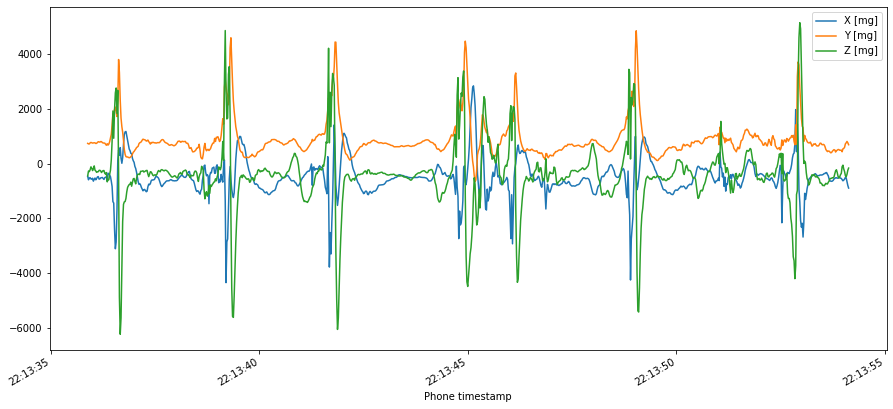

In [12]:
data_passe_avant.plot(figsize=(15,7))

In [ ]:
data_tir_avant = read_data_csv("Tir_avant.csv")
data_tir_avant.plot(figsize=(15,7))